In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/clean-data.csv")
df.head()

,Year,Geography Name,Poverty Estimate,Population Estimate,Poverty Percent
0,2015,Carlsbad,2088,19557,0.107
1,2015,Carlsbad,4525,48277,0.094
2,2015,Carlsbad,2063,19083,0.108
3,2015,Carlsbad,813,16958,0.048
4,2015,Carlsbad,579,6381,0.091


In [10]:
# เช็คว่าแต่ละคอลัมน์ มีค่าว่างกี่ช่อง
print(df.isnull().sum())

# เช็คประเภทของข้อมูลแต่ละคอลัมน์
print("\n เช็คประเภทของข้อมูลแต่ละคอลัมน์ :")
print(df.info())

# เช็คจำนวนแถวที่ซ้ำกัน
print("\n เช็คจำนวนแถวที่ซ้ำกัน :")
print(df.duplicated().sum())

# ตัวอย่าง: เช็คค่าที่ไม่ซ้ำในคอลัมน์ 'จังหวัด' (แก้ชื่อคอลัมน์ตามไฟล์จริงของคุณ)
# เปลี่ยน 'Column_Name' เป็นชื่อคอลัมน์ที่คุณสงสัย
print("\n เช็คค่าที่ไม่ซ้ำในคอลัมน์ :")
print(df['Year'].unique())


# ดูค่าทางสถิติ (ค่าต่ำสุด, สูงสุด, ค่าเฉลี่ย) ของคอลัมน์ตัวเลขทั้งหมด
print(df.describe())

Year                    0
Geography Name          0
Poverty Estimate        0
Population Estimate     0
Poverty Percent        89
dtype: int64

 เช็คประเภทของข้อมูลแต่ละคอลัมน์ :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7816 entries, 0 to 7815
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 7816 non-null   int64  
 1   Geography Name       7816 non-null   object 
 2   Poverty Estimate     7816 non-null   int64  
 3   Population Estimate  7816 non-null   int64  
 4   Poverty Percent      7727 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 305.4+ KB
None

 เช็คจำนวนแถวที่ซ้ำกัน :
149

 เช็คค่าที่ไม่ซ้ำในคอลัมน์ :
[2015 2020 2016 2017 2018 2019]
              Year  Poverty Estimate  Population Estimate  Poverty Percent
count  7816.000000       7816.000000         7.816000e+03      7727.000000
mean   2017.323439       1275.607600         1.026522e

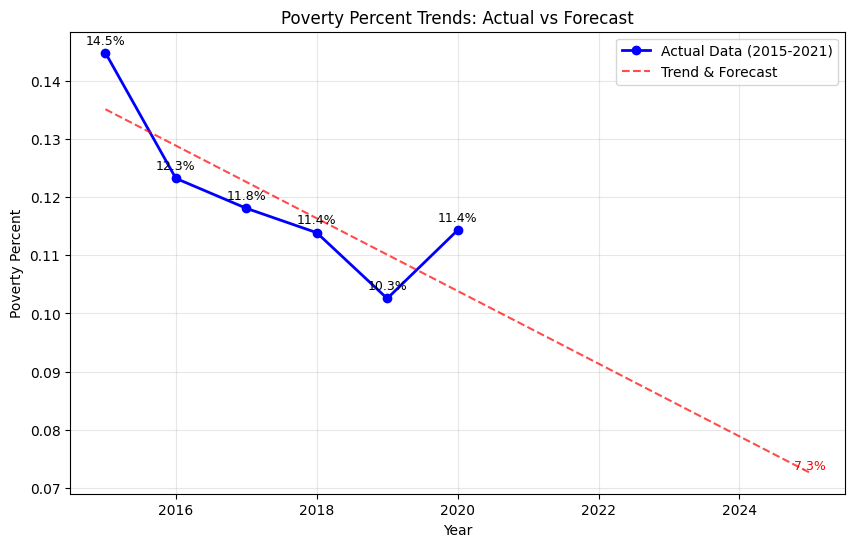

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the data
df = pd.read_csv('../data/clean-data.csv')

# Ensure 'Poverty Percent' is numeric
df['Poverty Percent'] = pd.to_numeric(df['Poverty Percent'], errors='coerce')

# Recalculate using weighted average (Total Poverty / Total Population)
df_weighted = df.groupby('Year')[['Poverty Estimate', 'Population Estimate']].sum().reset_index()
df_weighted['Weighted Poverty Percent'] = df_weighted['Poverty Estimate'] / df_weighted['Population Estimate']

# Prepare for Linear Regression
X_weighted = df_weighted['Year'].values.reshape(-1, 1)
y_weighted = df_weighted['Weighted Poverty Percent'].values

model_weighted = LinearRegression()
model_weighted.fit(X_weighted, y_weighted)

# Predict future years (e.g., next 5 years)
last_year = df_weighted['Year'].max()
future_years = np.arange(last_year, last_year + 6).reshape(-1, 1) # Start from last year to connect the lines
future_predictions = model_weighted.predict(future_years)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Actual Data as a Line
plt.plot(df_weighted['Year'], df_weighted['Weighted Poverty Percent'],
         marker='o', color='blue', linewidth=2, label='Actual Data (2015-2021)')

# Plot Forecast Data as a Line
# We append the last actual point to the future data to make the line continuous
forecast_years = np.concatenate(([df_weighted['Year'].iloc[-1]], future_years.flatten()))
# The first point of forecast should ideally be the last actual point OR the model's prediction for that year.
# To show the "trend" distinct from actuals, we usually plot the trend line separately or connect the last actual to the forecast.
# Let's plot the regression line for the whole period to show the trend fit, and then extend it.
all_years = np.arange(df_weighted['Year'].min(), last_year + 6).reshape(-1, 1)
all_predictions = model_weighted.predict(all_years)

plt.plot(all_years, all_predictions,
         linestyle='--', color='red', alpha=0.7, label='Trend & Forecast')

plt.title('Poverty Percent Trends: Actual vs Forecast')
plt.xlabel('Year')
plt.ylabel('Poverty Percent')
plt.legend()
plt.grid(True, alpha=0.3)

# Add data labels for actuals
for x, y in zip(df_weighted['Year'], df_weighted['Weighted Poverty Percent']):
    plt.text(x, y+0.001, f'{y:.1%}', ha='center', va='bottom', fontsize=9)

# Add data labels for the final forecast
plt.text(future_years[-1][0], future_predictions[-1], f'{future_predictions[-1]:.1%}',
         ha='center', va='bottom', color='red', fontsize=9)

plt.savefig('actual_vs_forecast_line.png')

Hybrid Model R-squared: 0.9999995565245832


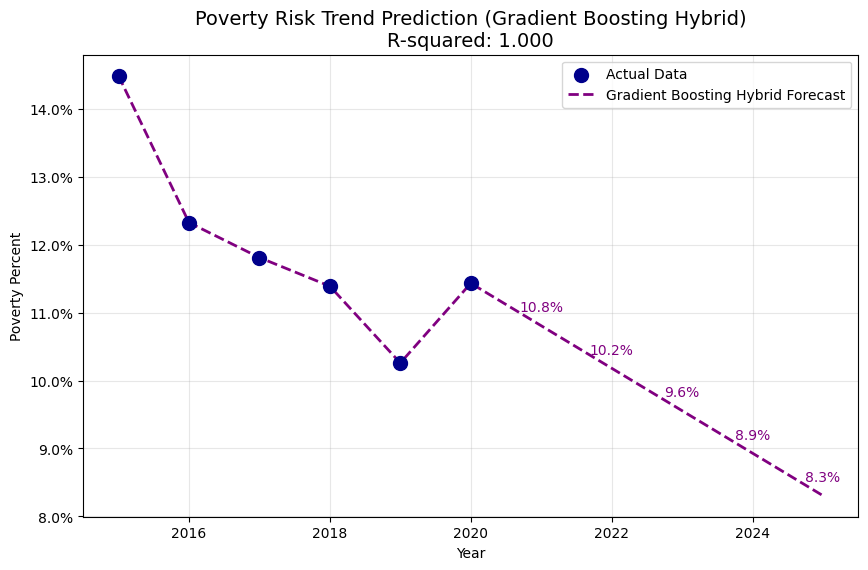

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Load and Preprocess
df = pd.read_csv('../data/clean-data.csv')
df['Poverty Percent'] = pd.to_numeric(df['Poverty Percent'], errors='coerce')
df_weighted = df.groupby('Year')[['Poverty Estimate', 'Population Estimate']].sum().reset_index()
df_weighted['Weighted Poverty Percent'] = df_weighted['Poverty Estimate'] / df_weighted['Population Estimate']

X = df_weighted[['Year']]
y = df_weighted['Weighted Poverty Percent']

# --- Hybrid Model Approach ---
# 1. Fit Linear Trend
linear_model = LinearRegression()
linear_model.fit(X, y)
y_trend = linear_model.predict(X)

# 2. Calculate Residuals
residuals = y - y_trend

# 3. Fit Gradient Boosting on Residuals (mimicking XGBoost behavior for non-linear part)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X, residuals)
y_res_pred = gb_model.predict(X)

# 4. Combine
y_pred_final = y_trend + y_res_pred

# --- Forecast ---
last_year = df_weighted['Year'].max()
future_years = np.arange(last_year + 1, last_year + 6).reshape(-1, 1)
future_df = pd.DataFrame(future_years, columns=['Year'])

# Predict Trend for future
future_trend = linear_model.predict(future_df)
# Predict Residuals for future (Note: Trees usually predict constant for out-of-bounds, so this will likely be near 0 or constant)
future_res = gb_model.predict(future_df)

future_pred_final = future_trend + future_res

# Metrics
r2 = r2_score(y, y_pred_final)
mse = mean_squared_error(y, y_pred_final)
print(f"Hybrid Model R-squared: {r2}")

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Actual Data
plt.scatter(df_weighted['Year'], df_weighted['Weighted Poverty Percent'],
            color='darkblue', s=100, label='Actual Data', zorder=5)

# Combined Forecast Line (Past + Future)
all_years = np.concatenate([df_weighted['Year'].values, future_years.flatten()])
all_preds = np.concatenate([y_pred_final, future_pred_final])

plt.plot(all_years, all_preds, color='purple', linestyle='--', linewidth=2, label='Gradient Boosting Hybrid Forecast')

# Annotations
plt.title(f'Poverty Risk Trend Prediction (Gradient Boosting Hybrid)\nR-squared: {r2:.3f}', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Poverty Percent')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Label future points
for i, txt in enumerate(future_pred_final):
    plt.annotate(f"{txt:.1%}", (future_years[i][0], future_pred_final[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', color='purple')

plt.savefig('gb_hybrid_forecast.png')

ARIMA(0,1,0) with trend summary:
                                  SARIMAX Results                                   
Dep. Variable:     Weighted Poverty Percent   No. Observations:                    6
Model:                       ARIMA(0, 1, 0)   Log Likelihood                  15.515
Date:                      Fri, 12 Dec 2025   AIC                            -27.030
Time:                              09:50:31   BIC                            -27.812
Sample:                          01-01-2015   HQIC                           -29.127
                               - 01-01-2020                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0061      0.005     -1.218      0.223      -0.016       0.004
sigma2         0.0001   9.58e-05      1.232      0

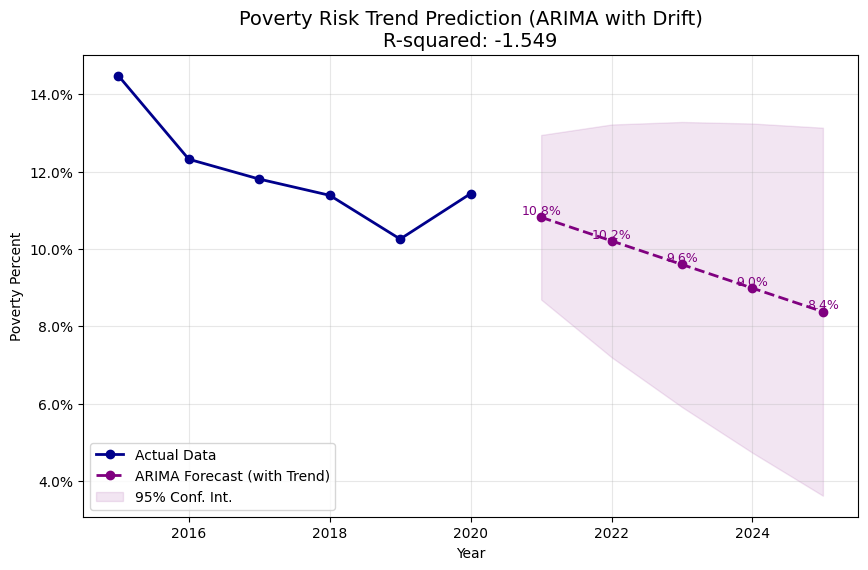

In [13]:
# Try ARIMA with a trend term to capture the downward slope
# ARIMA(0,1,0) with trend 't' is basically a random walk with drift,
# but since we have a clear deterministic trend, we might want ARIMA(1,0,0) with trend 't' or similar.
# Let's try ARIMA(0,1,0) with trend='t' (drift) first as it's standard for trending data.
# Actually, in statsmodels, 't' usually means linear trend.
# --- ARIMA Required Setup ---
try:
    # ARIMA(0,1,0) with trend is equivalent to Random Walk with Drift
    model_drift = ARIMA(ts_data, order=(0, 1, 0), trend='t')
    model_fit_drift = model_drift.fit()
    print("ARIMA(0,1,0) with trend summary:")
    print(model_fit_drift.summary())

    forecast_result_drift = model_fit_drift.get_forecast(steps=5)
    forecast_mean_drift = forecast_result_drift.predicted_mean
    conf_int_drift = forecast_result_drift.conf_int()

    # Calculate R2
    y_pred_drift = model_fit_drift.predict(start=ts_data.index[1], end=ts_data.index[-1])
    r2_drift = r2_score(ts_data[1:], y_pred_drift)
    print(f"R-squared with drift: {r2_drift}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(ts_data.index, ts_data.values, marker='o', color='darkblue', linewidth=2, label='Actual Data')
    plt.plot(forecast_mean_drift.index, forecast_mean_drift.values, marker='o', color='purple', linestyle='--', linewidth=2, label='ARIMA Forecast (with Trend)')
    plt.fill_between(forecast_mean_drift.index, conf_int_drift.iloc[:, 0], conf_int_drift.iloc[:, 1], color='purple', alpha=0.1, label='95% Conf. Int.')

    plt.title(f'Poverty Risk Trend Prediction (ARIMA with Drift)\nR-squared: {r2_drift:.3f}', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Poverty Percent')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    for i, val in enumerate(forecast_mean_drift):
        plt.text(forecast_mean_drift.index[i], val, f'{val:.1%}', ha='center', va='bottom', color='purple', fontsize=9)

    plt.savefig('arima_trend_forecast.png')

except Exception as e:
    print(f"ARIMA with trend failed: {e}")

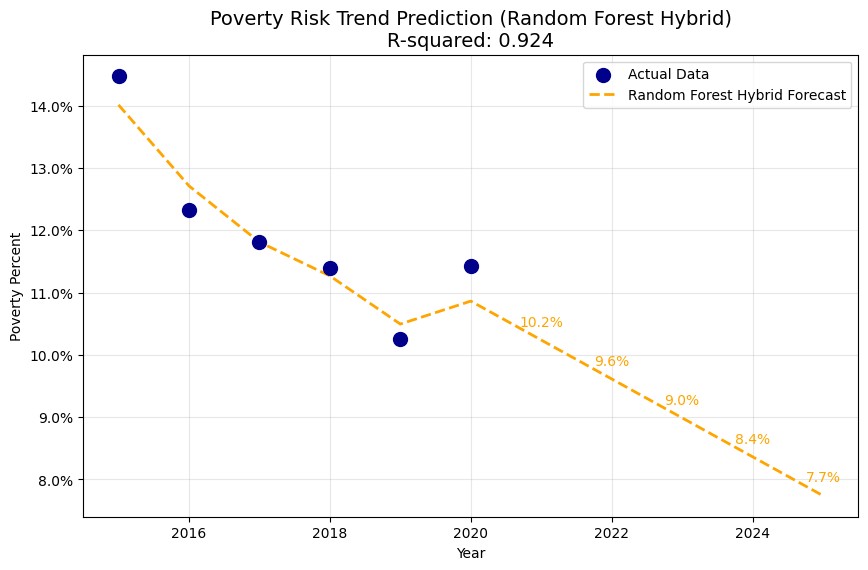

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Load Data
df = pd.read_csv('../data/clean-data.csv')

# Preprocessing
df['Poverty Percent'] = pd.to_numeric(df['Poverty Percent'], errors='coerce')
df_weighted = df.groupby('Year')[['Poverty Estimate', 'Population Estimate']].sum().reset_index()
df_weighted['Weighted Poverty Percent'] = df_weighted['Poverty Estimate'] / df_weighted['Population Estimate']

X = df_weighted[['Year']]
y = df_weighted['Weighted Poverty Percent']

# --- Hybrid Random Forest Approach ---
# 1. Fit Linear Trend (to handle extrapolation)
lin_model = LinearRegression()
lin_model.fit(X, y)
y_trend = lin_model.predict(X)

# 2. Calculate Residuals
residuals = y - y_trend

# 3. Fit Random Forest on Residuals
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X, residuals)
y_res_pred = rf_model.predict(X)

# 4. Combine In-sample Predictions
y_pred_final = y_trend + y_res_pred

# --- Forecast ---
last_year = df_weighted['Year'].max()
future_years = np.arange(last_year + 1, last_year + 6).reshape(-1, 1)
future_df = pd.DataFrame(future_years, columns=['Year'])

# Predict Future
future_trend = lin_model.predict(future_df)
future_res = rf_model.predict(future_df) # RF will likely predict constant residuals for future
future_pred_final = future_trend + future_res

# Metrics
r2 = r2_score(y, y_pred_final)

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Actual Data
plt.scatter(df_weighted['Year'], df_weighted['Weighted Poverty Percent'],
            color='darkblue', s=100, label='Actual Data', zorder=5)

# Combined Forecast Line (Past + Future)
all_years = np.concatenate([df_weighted['Year'].values, future_years.flatten()])
all_preds = np.concatenate([y_pred_final, future_pred_final])

plt.plot(all_years, all_preds, color='orange', linestyle='--', linewidth=2, label='Random Forest Hybrid Forecast')

# Annotations
plt.title(f'Poverty Risk Trend Prediction (Random Forest Hybrid)\nR-squared: {r2:.3f}', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Poverty Percent')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add labels to future points
for i, txt in enumerate(future_pred_final):
    plt.annotate(f"{txt:.1%}", (future_years[i][0], future_pred_final[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', color='orange')

plt.savefig('rf_hybrid_forecast.png')

09:50:31 - cmdstanpy - INFO - Chain [1] start processing
09:50:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\teeta\AppData\Local\Temp\ipykernel_4644\3036290328.py:53: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts_data = ts_data.asfreq('AS')


                    Model         R2           MSE
0                 Prophet   0.681962  5.314319e-05
1        XGBoost (Hybrid)   1.000000  7.410341e-11
2  Random Forest (Hybrid)   0.923622  1.276258e-05
3                   ARIMA -22.311586  3.895296e-03


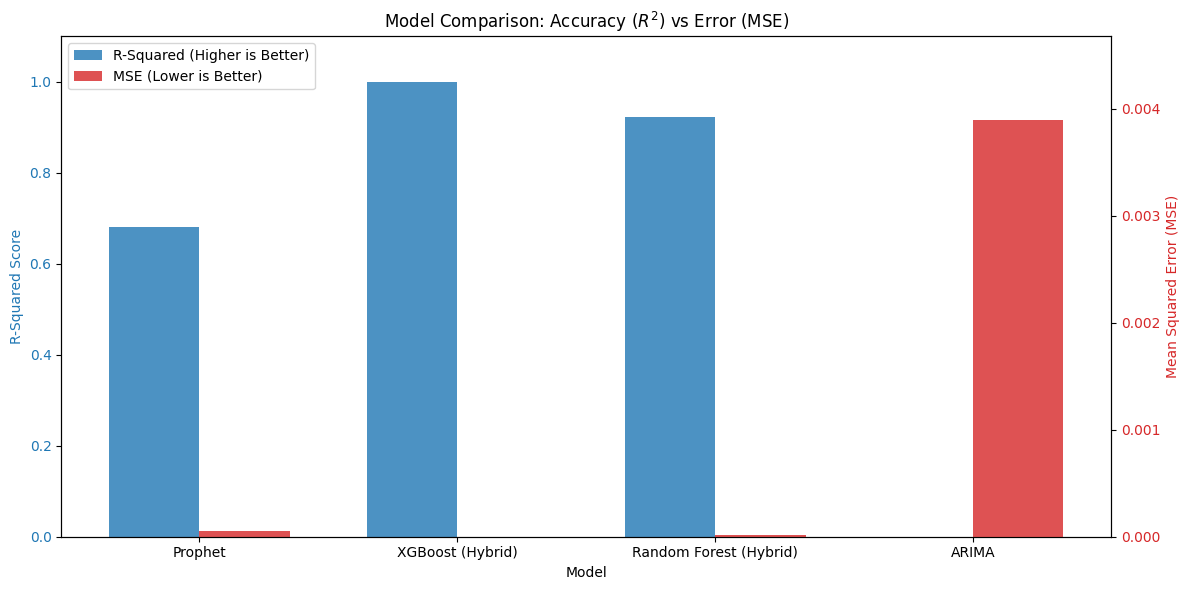

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# 1. Prepare Data
df = pd.read_csv('../data/clean-data.csv')
df['Poverty Percent'] = pd.to_numeric(df['Poverty Percent'], errors='coerce')
df_weighted = df.groupby('Year')[['Poverty Estimate', 'Population Estimate']].sum().reset_index()
df_weighted['Weighted Poverty Percent'] = df_weighted['Poverty Estimate'] / df_weighted['Population Estimate']

X = df_weighted[['Year']]
y = df_weighted['Weighted Poverty Percent']

# --- Model 1: Prophet ---
prophet_df = df_weighted.rename(columns={'Year': 'ds', 'Weighted Poverty Percent': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

model_prophet = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
model_prophet.fit(prophet_df)

future_prophet = model_prophet.make_future_dataframe(periods=0) # Only for existing dates
forecast_prophet = model_prophet.predict(future_prophet)

y_pred_prophet = forecast_prophet['yhat'].values
r2_prophet = r2_score(y, y_pred_prophet)
mse_prophet = mean_squared_error(y, y_pred_prophet)

# --- Model 2: Gradient Boosting Hybrid (Simulating XGBoost) ---
lr_trend = LinearRegression().fit(X, y)
trend_pred = lr_trend.predict(X)
residuals = y - trend_pred
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X, residuals)
y_pred_gb = trend_pred + gb_model.predict(X)
r2_gb = r2_score(y, y_pred_gb)
mse_gb = mean_squared_error(y, y_pred_gb)

# --- Model 3: Random Forest Hybrid ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, residuals)
y_pred_rf = trend_pred + rf_model.predict(X)
r2_rf = r2_score(y, y_pred_rf)
mse_rf = mean_squared_error(y, y_pred_rf)

# --- Model 4: ARIMA ---
ts_data = df_weighted.set_index('Year')['Weighted Poverty Percent']
ts_data.index = pd.to_datetime(ts_data.index, format='%Y')
ts_data = ts_data.asfreq('AS')

try:
    # Using ARIMA(0,1,0) with trend 't'
    arima_model = ARIMA(ts_data, order=(0, 1, 0), trend='t')
    arima_fit = arima_model.fit()
    y_pred_arima = arima_fit.predict(start=ts_data.index[0], end=ts_data.index[-1])
    # Align for metrics (drop the first point if necessary, but predict(start=0) usually handles it)
    # However, for R2, we need exact match.
    r2_arima = r2_score(y, y_pred_arima.values)
    mse_arima = mean_squared_error(y, y_pred_arima.values)
except:
    r2_arima = 0
    mse_arima = 0

# --- Compile Results ---
models = ['Prophet', 'XGBoost (Hybrid)', 'Random Forest (Hybrid)', 'ARIMA']
r2_scores = [r2_prophet, r2_gb, r2_rf, r2_arima]
mse_scores = [mse_prophet, mse_gb, mse_rf, mse_arima]

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 0.35
index = np.arange(len(models))

# Plot R2 on primary y-axis
rects1 = ax1.bar(index, r2_scores, bar_width, label='R-Squared (Higher is Better)', color='#1f77b4', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('R-Squared Score', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.set_ylim(0, 1.1)

# Plot MSE on secondary y-axis
ax2 = ax1.twinx()
rects2 = ax2.bar(index + bar_width, mse_scores, bar_width, label='MSE (Lower is Better)', color='#d62728', alpha=0.8)
ax2.set_ylabel('Mean Squared Error (MSE)', color='#d62728')
ax2.tick_params(axis='y', labelcolor='#d62728')
# Set MSE limit to make small bars visible? Or Log scale?
# MSE values are small (~1e-4), so linear scale is fine, but let's give some headroom.
ax2.set_ylim(0, max(mse_scores) * 1.2)

# Title and Labels
plt.title('Model Comparison: Accuracy ($R^2$) vs Error (MSE)')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models)

# Legend
# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('final_model_comparison_metrics.png')

# Print summary for response
print(pd.DataFrame({'Model': models, 'R2': r2_scores, 'MSE': mse_scores}))

Accuracy: 0.5575679172056921
Threshold used: 0.104
Confusion Matrix:
 [[420 347]
 [337 442]]


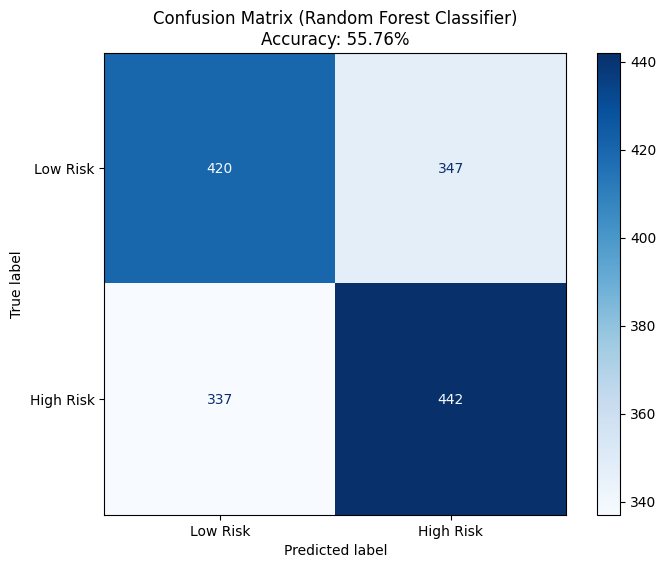

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import LabelEncoder

# 1. Load Data
df = pd.read_csv('../data/clean-data.csv')

# 2. Preprocessing
# Convert to numeric, coerce errors
df['Poverty Percent'] = pd.to_numeric(df['Poverty Percent'], errors='coerce')
df = df.dropna(subset=['Poverty Percent', 'Population Estimate', 'Geography Name'])

# Create Classification Target
# We define "High Risk" as Poverty Percent > Median of the dataset
threshold = df['Poverty Percent'].median()
df['Poverty_Class'] = (df['Poverty Percent'] > threshold).astype(int)

# Encode Categorical Features
le = LabelEncoder()
df['Geography_Code'] = le.fit_transform(df['Geography Name'])

# Select Features and Target
feature_cols = ['Year', 'Population Estimate', 'Geography_Code']
X = df[feature_cols]
y = df['Poverty_Class']

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Model (Random Forest Classifier - widely considered a strong performer)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 5. Predict
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# 6. Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'High Risk'])

# 7. Plotting
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title(f'Confusion Matrix (Random Forest Classifier)\nAccuracy: {acc:.2%}')
plt.grid(False) # Turn off grid for CM
plt.savefig('confusion_matrix.png')

print(f"Accuracy: {acc}")
print(f"Threshold used: {threshold}")
print("Confusion Matrix:\n", cm)

Model Evaluation:
Logistic Regression: 0.5013
Random Forest: 0.5576
Gradient Boosting: 0.6300

Best Model: Gradient Boosting with Accuracy: 0.6300


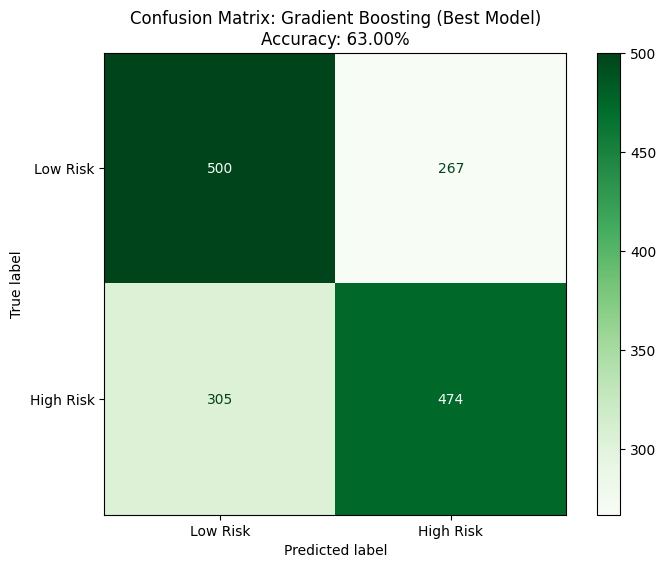

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

best_name = ""
best_acc = 0
best_model = None
best_cm = None
best_y_pred = None

# Iterate and evaluate
print("Model Evaluation:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_loop = model.predict(X_test)
    acc_loop = accuracy_score(y_test, y_pred_loop)
    print(f"{name}: {acc_loop:.4f}")

    if acc_loop > best_acc:
        best_acc = acc_loop
        best_name = name
        best_model = model
        best_cm = confusion_matrix(y_test, y_pred_loop)
        best_y_pred = y_pred_loop

print(f"\nBest Model: {best_name} with Accuracy: {best_acc:.4f}")

# Plot Confusion Matrix for the Winner
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=['Low Risk', 'High Risk'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Greens', values_format='d', ax=plt.gca()) # Green for 'Best'
plt.title(f'Confusion Matrix: {best_name} (Best Model)\nAccuracy: {best_acc:.2%}')
plt.grid(False)
plt.savefig('best_model_confusion_matrix.png')

In [18]:
import pandas as pd

# Ensure df is loaded (if not already from previous cells)
# df = pd.read_csv('/content/sample_data/clean-data.csv')

# Filter the DataFrame for 'San Diego County'
# Note: From previous checks, 'San Diego County' might not be an exact match.
# If this filter results in an empty DataFrame, please check the unique geography names.
filtered_df = df[df['Geography Name'] == 'San Diego County']

if filtered_df.empty:
    print("No data found for 'San Diego County'. Please check the exact spelling or available names.")
    print("Unique values in 'Geography Name' column:")
    print(df['Geography Name'].unique())
else:
    # 1. Calculate the overall total population below the poverty line for 'San Diego County'
    total_poverty_estimate_filtered = filtered_df['Poverty Estimate'].sum()
    print(f"\nTotal Population Below Poverty Line (San Diego County): {total_poverty_estimate_filtered:,}")

    # Recalculate df_weighted for the filtered data
    # This ensures consistency if df_weighted was based on the full df before.
    df_weighted_filtered = filtered_df.groupby('Year')[['Poverty Estimate', 'Population Estimate']].sum().reset_index()
    df_weighted_filtered['Weighted Poverty Percent'] = df_weighted_filtered['Poverty Estimate'] / df_weighted_filtered['Population Estimate']

    # 2. Calculate the population below the poverty line by year for 'San Diego County'
    poverty_by_year_filtered = df_weighted_filtered[['Year', 'Poverty Estimate']]
    print("\nPopulation Below Poverty Line by Year (San Diego County):")
    display(poverty_by_year_filtered)


Total Population Below Poverty Line (San Diego County): 5,796,894

Population Below Poverty Line by Year (San Diego County):


,Year,Poverty Estimate
0,2015,1332780
1,2016,1195425
2,2017,1153626
3,2018,1113477
4,2019,1001586


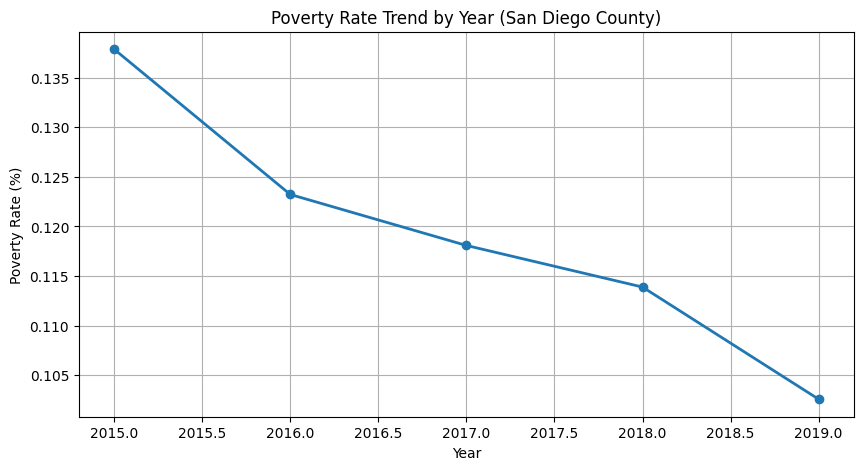

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_weighted_filtered['Year'], 
         df_weighted_filtered['Weighted Poverty Percent'], 
         marker='o', linewidth=2)

plt.title('Poverty Rate Trend by Year (San Diego County)')
plt.xlabel('Year')
plt.ylabel('Poverty Rate (%)')
plt.grid(True)

plt.show()


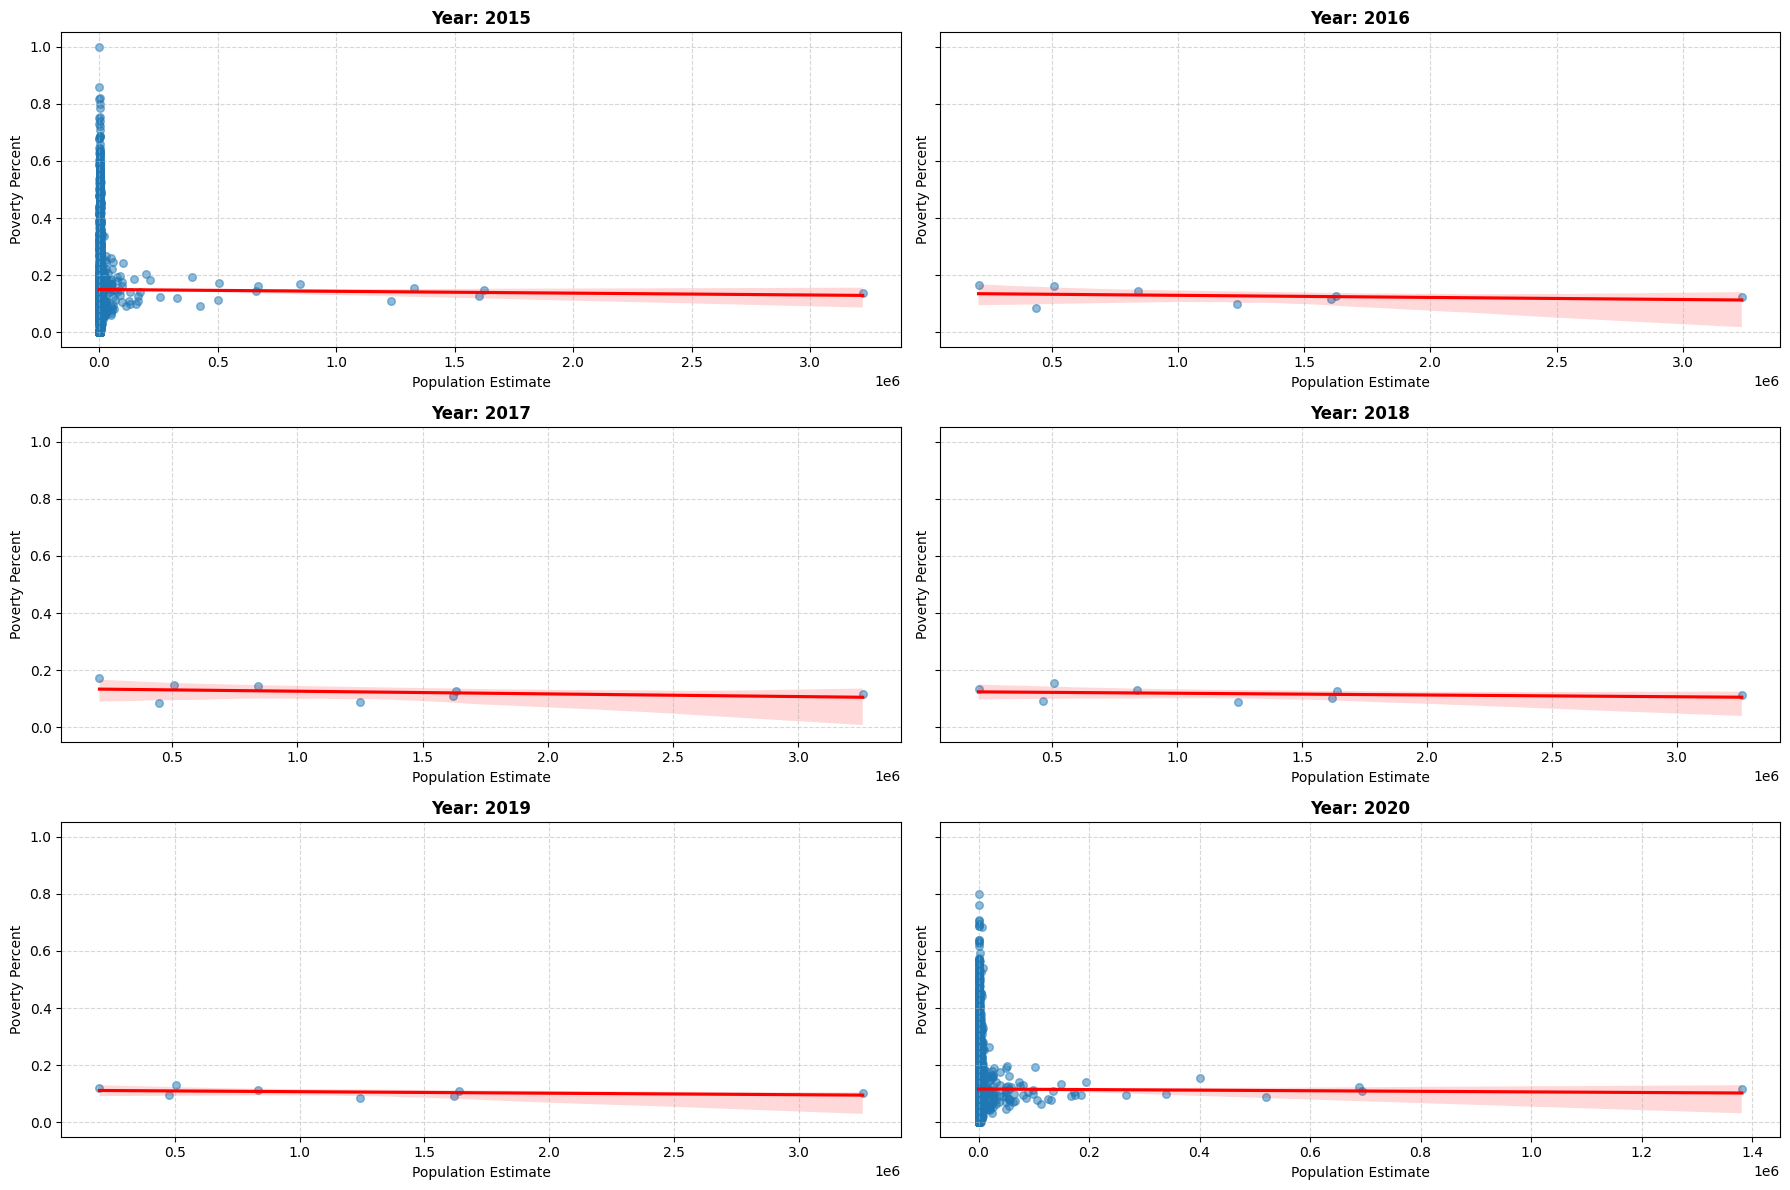

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
df = pd.read_csv('../data/clean-data.csv')

# Clean data
df_clean = df.dropna(subset=['Population Estimate', 'Poverty Percent', 'Year'])

# Setup the figure for 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=False, sharey=True)
axes = axes.flatten()

# Get unique years sorted
years = sorted(df_clean['Year'].unique())

for i, year in enumerate(years):
    # Filter data for the specific year
    data_year = df_clean[df_clean['Year'] == year]

    # Plot Scatter plot with Trend Line using regplot
    # scatter_kws controls the points (dots), line_kws controls the trend line
    sns.regplot(
        data=data_year,
        x='Population Estimate',
        y='Poverty Percent',
        ax=axes[i],
        scatter_kws={'alpha': 0.5, 's': 30}, # Translucent dots
        line_kws={'color': 'red'} # Red trend line
    )

    # Customization
    axes[i].set_title(f'Year: {year}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Population Estimate')
    axes[i].set_ylabel('Poverty Percent')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.savefig('poverty_vs_population_trendline.png')

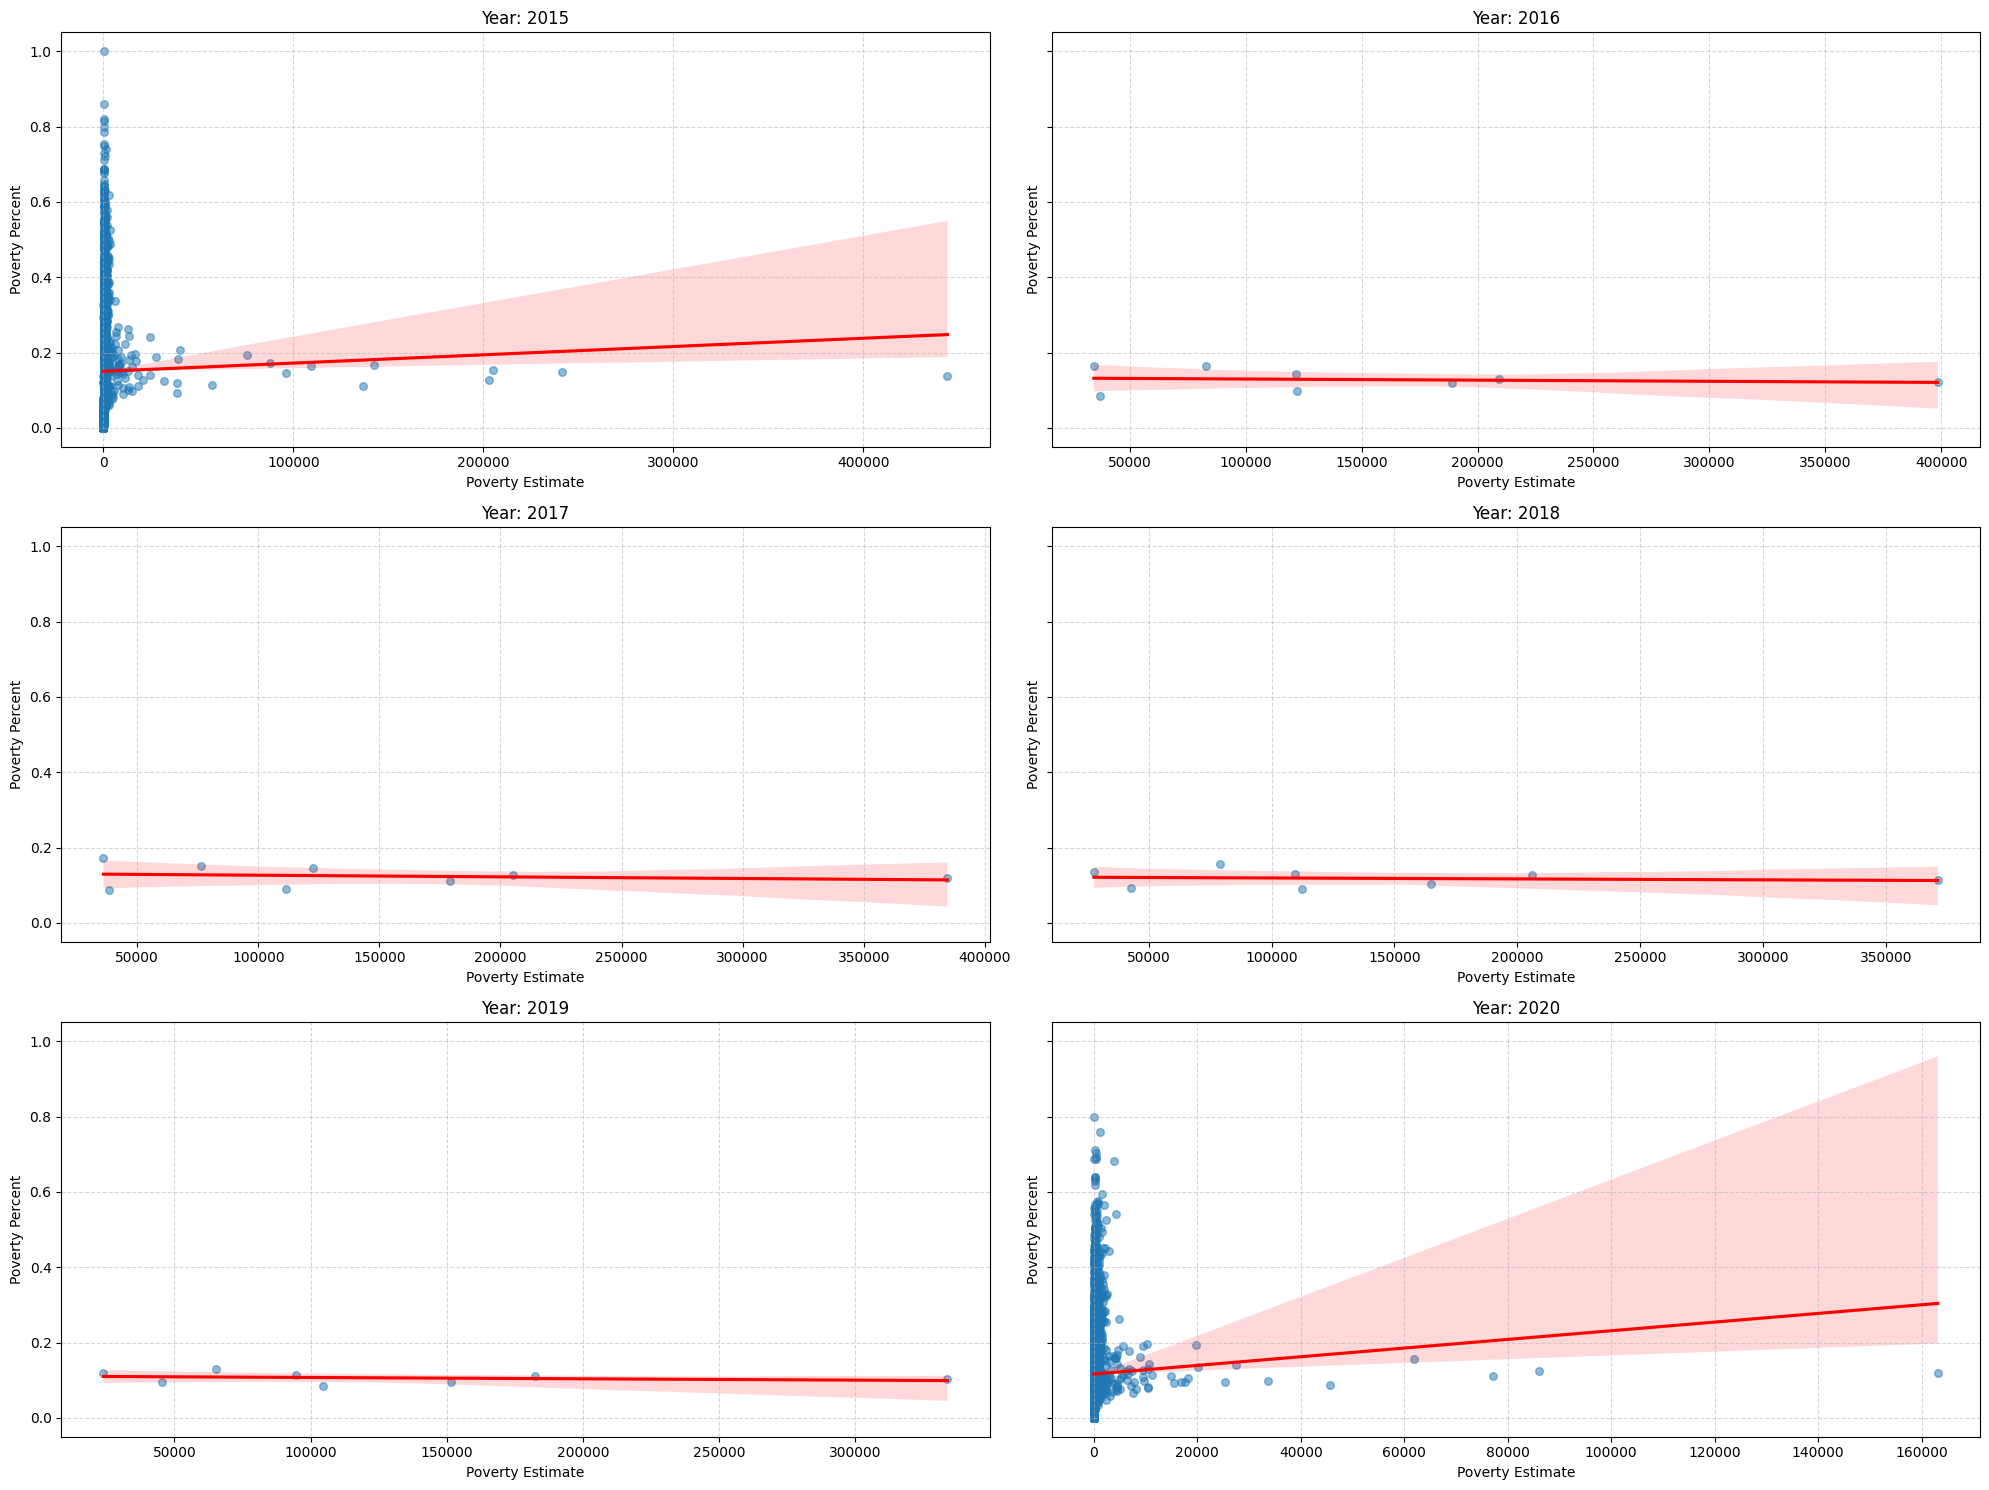

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# โหลดข้อมูล
df = pd.read_csv('../data/clean-data.csv')
df_clean = df.dropna(subset=['Poverty Estimate', 'Poverty Percent', 'Year'])

# ตั้งค่าหน้ากระดาษ
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True)
axes = axes.flatten()
years = sorted(df_clean['Year'].unique())

for i, year in enumerate(years):
    data_year = df_clean[df_clean['Year'] == year]

    # สร้างกราฟ Scatter พร้อม Trend Line
    sns.regplot(
        data=data_year,
        x='Poverty Estimate',
        y='Poverty Percent',
        ax=axes[i],
        scatter_kws={'alpha': 0.5, 's': 30},
        line_kws={'color': 'red'}
    )

    axes[i].set_title(f'Year: {year}')
    axes[i].set_xlabel('Poverty Estimate')
    axes[i].set_ylabel('Poverty Percent')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('poverty_percent_vs_estimate_trendline.png')

C:\Users\teeta\AppData\Local\Temp\ipykernel_4644\2426733676.py:30: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
C:\Users\teeta\AppData\Local\Temp\ipykernel_4644\2426733676.py:30: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
C:\Users\teeta\AppData\Local\Temp\ipykernel_4644\2426733676.py:30: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
C:\Users\teeta\AppData\Local\Temp\ipykernel_4644\2426733676.py:30: UserWarning: 

The `scale` parameter is depre

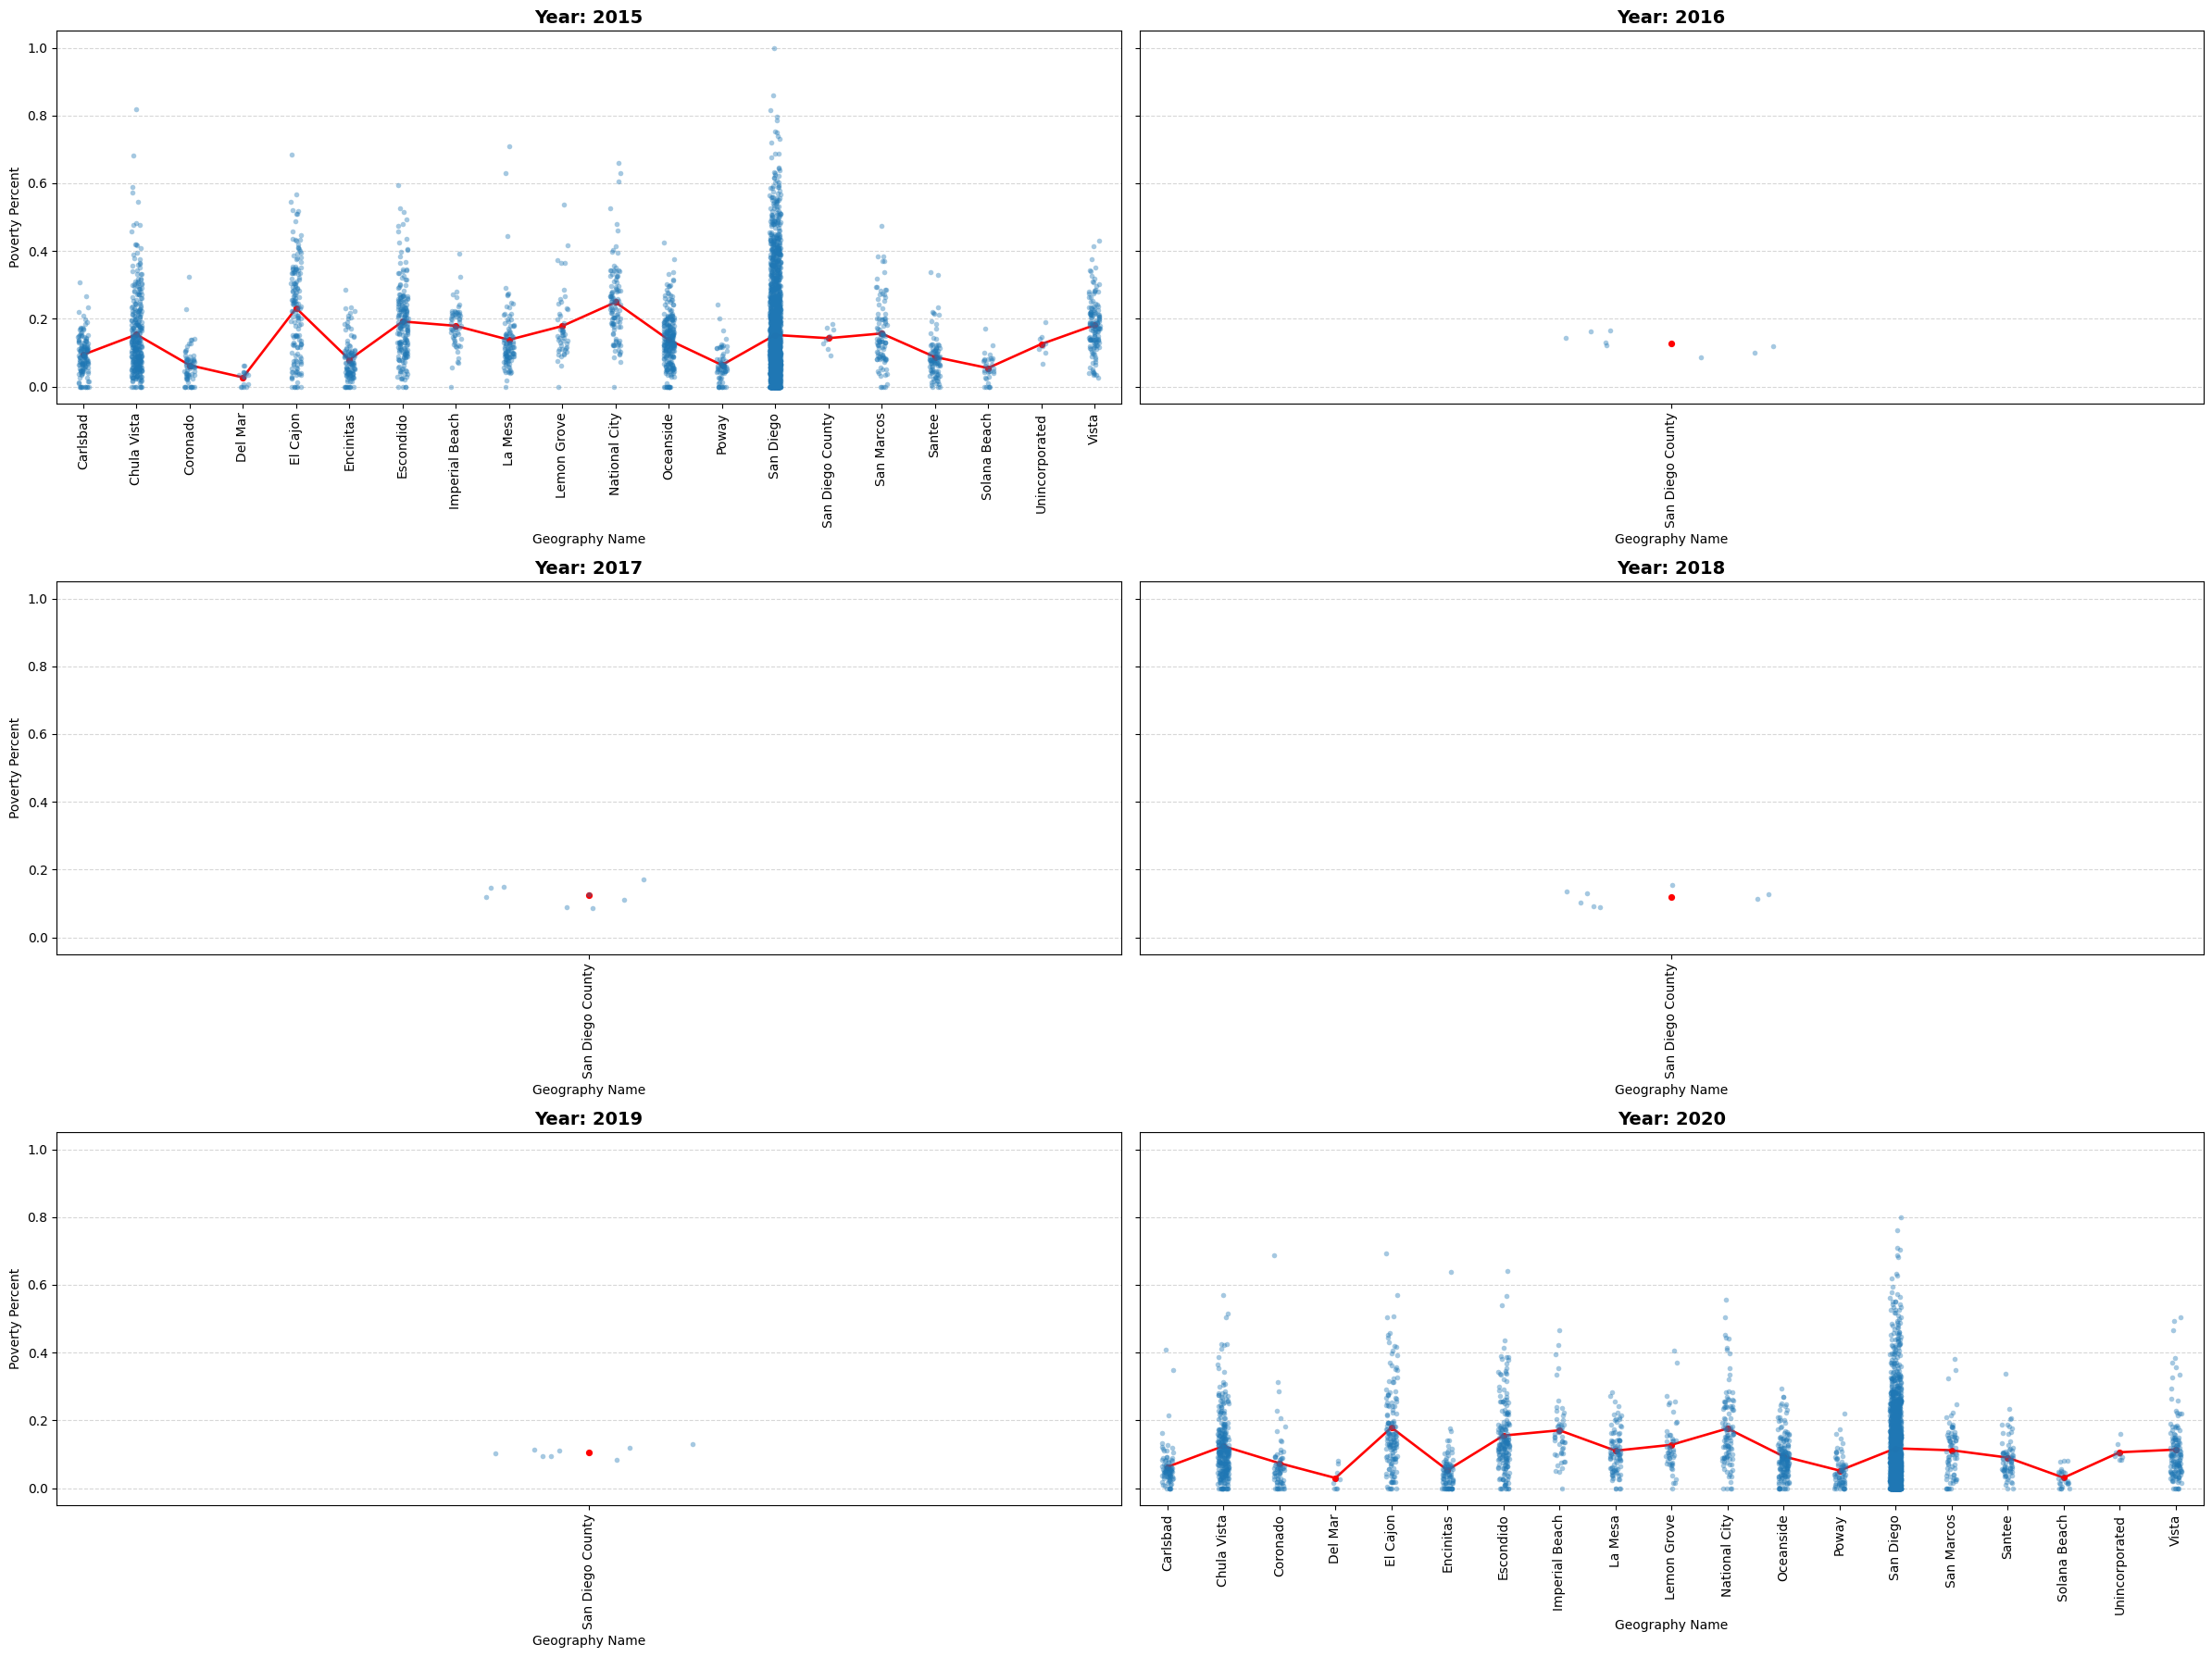

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# โหลดข้อมูล
df = pd.read_csv('../data/clean-data.csv')
df_clean = df.dropna(subset=['Geography Name', 'Poverty Percent', 'Year'])

# ตั้งค่าหน้ากระดาษ
fig, axes = plt.subplots(3, 2, figsize=(24, 18), sharey=True)
axes = axes.flatten()
years = sorted(df_clean['Year'].unique())

for i, year in enumerate(years):
    data_year = df_clean[df_clean['Year'] == year].sort_values('Geography Name')

    # 1. สร้างจุด (Scatter) เพื่อโชว์ข้อมูลดิบ
    sns.stripplot(
        data=data_year,
        x='Geography Name',
        y='Poverty Percent',
        ax=axes[i],
        alpha=0.4,
        size=4,
        color='#1f77b4',
        jitter=True
    )

    # 2. สร้างเส้นเชื่อมค่าเฉลี่ย (Point Plot) แทนเส้น Trend Line
    sns.pointplot(
        data=data_year,
        x='Geography Name',
        y='Poverty Percent',
        ax=axes[i],
        color='red',
        scale=0.7,
        errorbar=None
    )

    # ตกแต่งกราฟ
    axes[i].set_title(f'Year: {year}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Geography Name')
    axes[i].set_ylabel('Poverty Percent')
    axes[i].tick_params(axis='x', rotation=90) # หมุนชื่อเมืองให้อ่านง่าย
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('poverty_percent_vs_geography_points_mean.png')